Problem Statement - You are a cab rental staff-up company. You have successfully run the pilot project and now want to launch your cab service across the country You have collected the historical data from your pilot project and now have a requirement to apply analytics for fare prediction. You need to design a system that predicts the fare amount for a cab ride in the city

In [87]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [154]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pprint import pprint
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Understanding the Data

In [89]:
train = pd.read_csv("train_cab_fare.csv")
test = pd.read_csv("test_cab_fare.csv")

In [90]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [91]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [92]:
train.shape

(16067, 7)

In [93]:
test.shape

(9914, 6)

In [94]:
train.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [95]:
test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [96]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [97]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963642,40.768014,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


# Data Pre-Processing

## Missing Values Analysis

In [98]:
# Convert fare_amount from object to numeric
train["fare_amount"] = pd.to_numeric(train["fare_amount"],errors= "coerce")


In [99]:
train.dropna(subset = ["pickup_datetime"])

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0
...,...,...,...,...,...,...,...
16062,6.5,2014-12-12 07:41:00 UTC,-74.008820,40.718757,-73.998865,40.719987,1.0
16063,16.1,2009-07-13 07:58:00 UTC,-73.981310,40.781695,-74.014392,40.715527,2.0
16064,8.5,2009-11-11 11:19:07 UTC,-73.972507,40.753417,-73.979577,40.765495,1.0
16065,8.1,2010-05-11 23:53:00 UTC,-73.957027,40.765945,-73.981983,40.779560,1.0


In [100]:
train["pickup_datetime"] = pd.to_datetime(
    train["pickup_datetime"],
    errors="coerce",   # invalid values like "43" → NaT
    utc=True           # makes datetimes timezone-aware
)


In [101]:
# We will saperate the Pickup_datetime column into separate field like year,month,day of the week

train['Year'] = train['pickup_datetime'].dt.year
train['Month'] = train['pickup_datetime'].dt.month
train['Date'] = train['pickup_datetime'].dt.day
train['Day'] = train['pickup_datetime'].dt.dayofweek
train['Hour'] = train['pickup_datetime'].dt.hour
train['Minute'] = train['pickup_datetime'].dt.minute

In [102]:
# Rechecking data types after conversion
train.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
Year                             float64
Month                            float64
Date                             float64
Day                              float64
Hour                             float64
Minute                           float64
dtype: object

In [103]:
test["pickup_datetime"]=pd.to_datetime(test["pickup_datetime"],format="%Y-%m-%d %H:%M:%S UTC")

In [104]:
# We will saperate the Pickup_datetime column into separate field like year, month, day of the week

test['Year']=test['pickup_datetime'].dt.year
test['Month']=test['pickup_datetime'].dt.month
test['Date']=test['pickup_datetime'].dt.day
test['Day']=test['pickup_datetime'].dt.dayofweek
test['Hour']=test['pickup_datetime'].dt.hour
test['Minute']=test['pickup_datetime'].dt.minute

In [105]:
# Re-checking test datatypes after conversion
test.dtypes

pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
Year                          int32
Month                         int32
Date                          int32
Day                           int32
Hour                          int32
Minute                        int32
dtype: object

# Observation
1. An outlier in pickup_datetime column of value 43
2. Latitudes range from -90 to 90
3. Longitudes range from -180 to 180
4. Passenger count should not exceed 6
5. Few missing values and High values of fare and Passenger count are present. So, decided to remove them.

In [106]:
# Removing pickup_datetime missing values rows

train = train.drop(train[train['pickup_datetime'].isnull()].index, axis=0)
print(train.shape)
print(train['pickup_datetime'].isnull().sum())

(16066, 13)
0


In [107]:
# Checking passenger count variable

train['passenger_count'].describe()

count    16011.000000
mean         2.625171
std         60.846021
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

# Observations
1. We can see maximum number of passanger count is 5345 which is actually not possible. So,reducing the passenger count to 6.


2. We also need to remove passenger count having 0 value

In [108]:
# Removing the passanger count having count>6

train = train.drop(train[train["passenger_count"]> 6 ].index, axis=0)

In [109]:
# Removing the values with passenger count of 0
train = train.drop(train[train["passenger_count"] == 0 ].index, axis=0)

In [110]:
train["passenger_count"].describe()

count    15934.000000
mean         1.649581
std          1.265943
min          0.120000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [111]:
train["passenger_count"].sort_values(ascending=True)

8862     0.12
0        1.00
9790     1.00
9791     1.00
9792     1.00
         ... 
8076      NaN
8139      NaN
8259      NaN
8306      NaN
16066     NaN
Name: passenger_count, Length: 15989, dtype: float64

In [112]:
# Removing passanger_count missing values rows

train = train.drop(train[train['passenger_count'].isnull()].index, axis=0)
print(train.shape)
print(train['passenger_count'].isnull().sum())

(15934, 13)
0


In [113]:
# There is one passenger count value of 0.12 which is not possible. 
# Hence we will remove fractional passenger value
train=train.drop(train[train['passenger_count']==0.12].index, axis=0)

In [114]:
train.shape

(15933, 13)

In [115]:
# Finding decending order of fare_amount to get to know whether the outliers are present or not
train["fare_amount"].sort_values(ascending=False)

1015    54343.0
1072     4343.0
607       453.0
980       434.0
1335      180.0
         ...   
1712        NaN
2412        NaN
2458        NaN
8178        NaN
8226        NaN
Name: fare_amount, Length: 15933, dtype: float64

In [116]:
# Fare amount has a negative value, which doesn't make sense. 
Counter(train["fare_amount"]<0)

Counter({False: 15930, True: 3})

In [117]:
# Remove those fields which has -ve values
train=train.drop(train[train['fare_amount']<0].index, axis=0)
print(train.shape)

(15930, 13)


In [118]:
# Make sure there is no negative values in the fare_amount variable column
train["fare_amount"].min()

0.0

In [119]:
# Remove the row where fare amount is zero
train=train.drop(train[train['fare_amount']<1].index,axis=0)
train.shape

(15928, 13)

In [120]:
# fare_amount variable in descending order

train['fare_amount'].sort_values(ascending=False)

1015    54343.0
1072     4343.0
607       453.0
980       434.0
1335      180.0
         ...   
1712        NaN
2412        NaN
2458        NaN
8178        NaN
8226        NaN
Name: fare_amount, Length: 15928, dtype: float64

In [121]:
# Removing the missing value rows

train=train.drop(train[train["fare_amount"].isnull()].index, axis=0)
train.shape

(15904, 13)

In [122]:
# Removing the outlier 54343 and 4343 which are far greater than 453

train=train.drop(train[train["fare_amount"]>453].index, axis=0)
train.shape

(15902, 13)

In [123]:
# fare_amount variable in descending order

train['fare_amount'].sort_values(ascending=False)

607      453.00
980      434.00
1335     180.00
1483     165.00
6630     128.83
          ...  
8596       2.50
7918       2.50
8603       2.50
15490      2.50
1427       1.14
Name: fare_amount, Length: 15902, dtype: float64

In [124]:
train['fare_amount'].describe()

count    15902.000000
mean        11.376356
std         10.814908
min          1.140000
25%          6.000000
50%          8.500000
75%         12.500000
max        453.000000
Name: fare_amount, dtype: float64

In [125]:
# Lattitude----> (-90 to 90)
# Longitude----> (-180 to 180)

# We need to drop the rows having  pickup_lattitude and pickup_longitude out of the above mentioned range

train[train['pickup_latitude']<-90]
train[train['pickup_latitude']>90]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute
5686,3.3,2011-07-30 11:15:00+00:00,-73.947235,401.083332,-73.951392,40.778927,1.0,2011.0,7.0,30.0,5.0,11.0,15.0


In [126]:
# Dropping one row having the value >90
train = train.drop((train[train['pickup_latitude']<-90]).index, axis=0)
train = train.drop((train[train['pickup_latitude']>90]).index, axis=0)

In [127]:
train['pickup_latitude'].sort_values(ascending=False)

3075     41.366138
4487     41.366138
14367    41.366138
6416     41.366138
9808     41.366138
           ...    
3827    -73.988467
4783    -73.991840
9548    -73.992947
10091   -74.006210
8443    -74.006893
Name: pickup_latitude, Length: 15901, dtype: float64

In [128]:
train[train['pickup_longitude']<-180]
train[train['pickup_longitude']>180]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute


No values in that range

In [129]:
train.shape

(15901, 13)

In [130]:
train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [131]:
test.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day                  0
Hour                 0
Minute               0
dtype: int64

Now, we cleared both the dataset (train and test) which can be further used for data analysis.

In [132]:
# As we have given pickup_longitute and pickup_latitude values.So,we need to calculate the distance using the haversine formula.
# Haversine formula(the great circle distance between two points on the earth (specified in decimal degrees))

from math import radians, cos, sin, asin, sqrt
def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
     # Radius of earth in kilometers is 6371
    km = 6371* c
    return km
    


In [133]:
train['distance'] = train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon1=a[0]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat1=a[1]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon2=a[2]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:9: Futu

In [134]:
test['distance'] = test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon1=a[0]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat1=a[1]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon2=a[2]
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_144\3643029367.py:9: Futu

In [135]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009.0,6.0,15.0,0.0,17.0,26.0,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010.0,1.0,5.0,1.0,16.0,52.0,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011.0,8.0,18.0,3.0,0.0,35.0,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012.0,4.0,21.0,5.0,4.0,30.0,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010.0,3.0,9.0,1.0,7.0,51.0,1.999157


In [136]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute,distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,8,2.323259
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,8,2.425353
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,53,0.618628
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,12,1.961033
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,12,5.387301


In [137]:
train.nunique()

fare_amount            459
pickup_datetime      15856
pickup_longitude     13672
pickup_latitude      14110
dropoff_longitude    13763
dropoff_latitude     14136
passenger_count          7
Year                     7
Month                   12
Date                    31
Day                      7
Hour                    24
Minute                  60
distance             15448
dtype: int64

In [138]:
test.nunique()


pickup_datetime      1753
pickup_longitude     9124
pickup_latitude      9246
dropoff_longitude    9141
dropoff_latitude     9360
passenger_count         6
Year                    7
Month                  12
Date                   31
Day                     7
Hour                   24
Minute                 60
distance             9830
dtype: int64

In [139]:
# Finding decending order of distance to get to know whether the outliers are presented or not.

train['distance'].sort_values(ascending=False)

9147     8667.542104
8647     8667.497512
2397     8667.454421
472      8667.304968
11653    8666.701504
            ...     
8982        0.000000
7009        0.000000
4769        0.000000
3711        0.000000
12478       0.000000
Name: distance, Length: 15901, dtype: float64

# Observations
1. As we can see that top 23 values in the distance variables are very high.
2. It means more than 8000 Kms distance they have travelled.
3. Just after 23rd value from the top, the distance goes down to 129, which means these values are showing some outliers.
4. We need to remove these values.

In [140]:
Counter(train['distance'] == 0)

Counter({False: 15447, True: 454})

In [141]:
Counter(test['distance']==0)

Counter({False: 9829, True: 85})

In [142]:
# We will remove the rows whose distance value is zero

train = train.drop(train[train['distance']== 0].index, axis=0)
train.shape

(15447, 14)

In [143]:
# We will remove the rows whose distance values is very high, which is more than 129kms.

train = train.drop(train[train['distance'] > 130 ].index, axis=0)
train.shape

(15424, 14)

In [144]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009.0,6.0,15.0,0.0,17.0,26.0,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010.0,1.0,5.0,1.0,16.0,52.0,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011.0,8.0,18.0,3.0,0.0,35.0,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012.0,4.0,21.0,5.0,4.0,30.0,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010.0,3.0,9.0,1.0,7.0,51.0,1.999157


# Observations
Now, we have splitted the pickup_datetime variable into different varaibles like month, year, day etc. Now, we dont need to have that pickup_datetime variable. Hence we can drop that.

In [145]:
drop1 = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'Minute']

train = train.drop(drop1, axis = 1)

In [146]:
train.head()

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,distance
0,4.5,1.0,2009.0,6.0,15.0,0.0,17.0,1.030764
1,16.9,1.0,2010.0,1.0,5.0,1.0,16.0,8.450134
2,5.7,2.0,2011.0,8.0,18.0,3.0,0.0,1.389525
3,7.7,1.0,2012.0,4.0,21.0,5.0,4.0,2.799270
4,5.3,1.0,2010.0,3.0,9.0,1.0,7.0,1.999157


In [147]:
train['passenger_count'] = train['passenger_count'].astype('int64')
train['Year'] = train['Year'].astype('int64')
train['Month'] = train['Month'].astype('int64')
train['Date'] = train['Date'].astype('int64')
train['Day'] = train['Day'].astype('int64')
train['Hour'] = train['Hour'].astype('int64')

In [148]:
train.dtypes

fare_amount        float64
passenger_count      int64
Year                 int64
Month                int64
Date                 int64
Day                  int64
Hour                 int64
distance           float64
dtype: object

In [149]:
drop2 = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'Minute']

test = test.drop(drop2, axis = 1)

In [150]:
test.head()

,passenger_count,Year,Month,Date,Day,Hour,distance
0,1,2015,1,27,1,13,2.323259
1,1,2015,1,27,1,13,2.425353
2,1,2011,10,8,5,11,0.618628
3,1,2012,12,1,5,21,1.961033
4,1,2012,12,1,5,21,5.387301


In [151]:
test['passenger_count'] = test['passenger_count'].astype('int64')
test['Year'] = test['Year'].astype('int64')
test['Month'] = test['Month'].astype('int64')
test['Date'] = test['Date'].astype('int64')
test['Day'] = test['Day'].astype('int64')
test['Hour'] = test['Hour'].astype('int64')

In [152]:
test.dtypes

passenger_count      int64
Year                 int64
Month                int64
Date                 int64
Day                  int64
Hour                 int64
distance           float64
dtype: object

DATA VISUALIZATION


<Axes: xlabel='passenger_count', ylabel='count'>

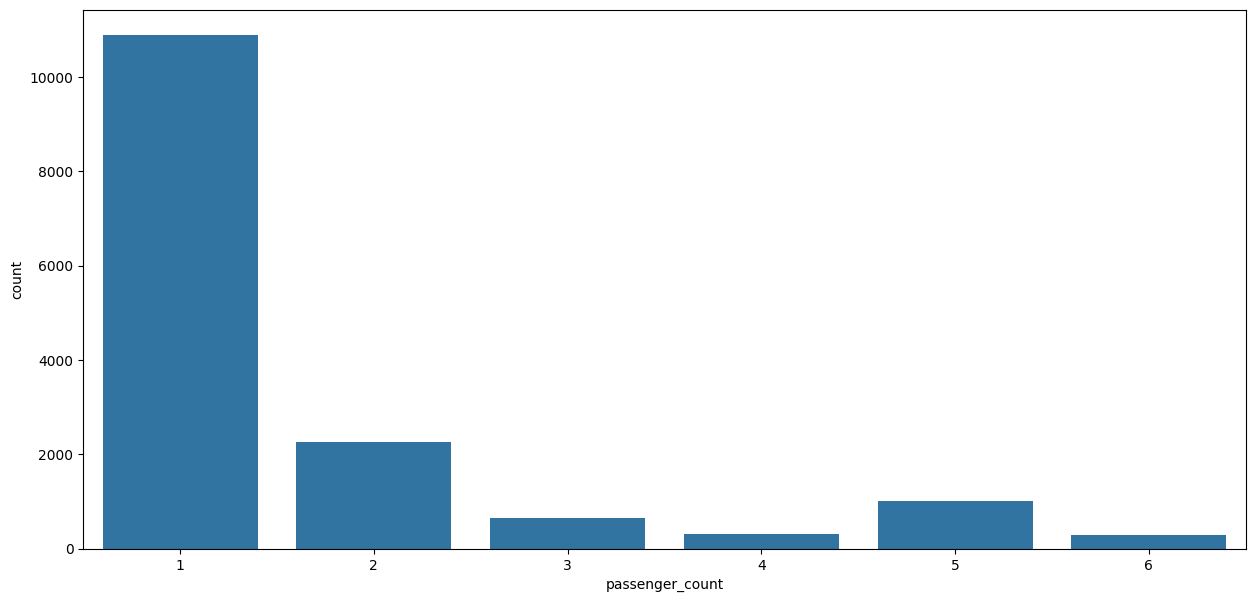

In [155]:
# Count plot on passenger count

plt.figure(figsize=(15,7))
sns.countplot(x="passenger_count", data=train)

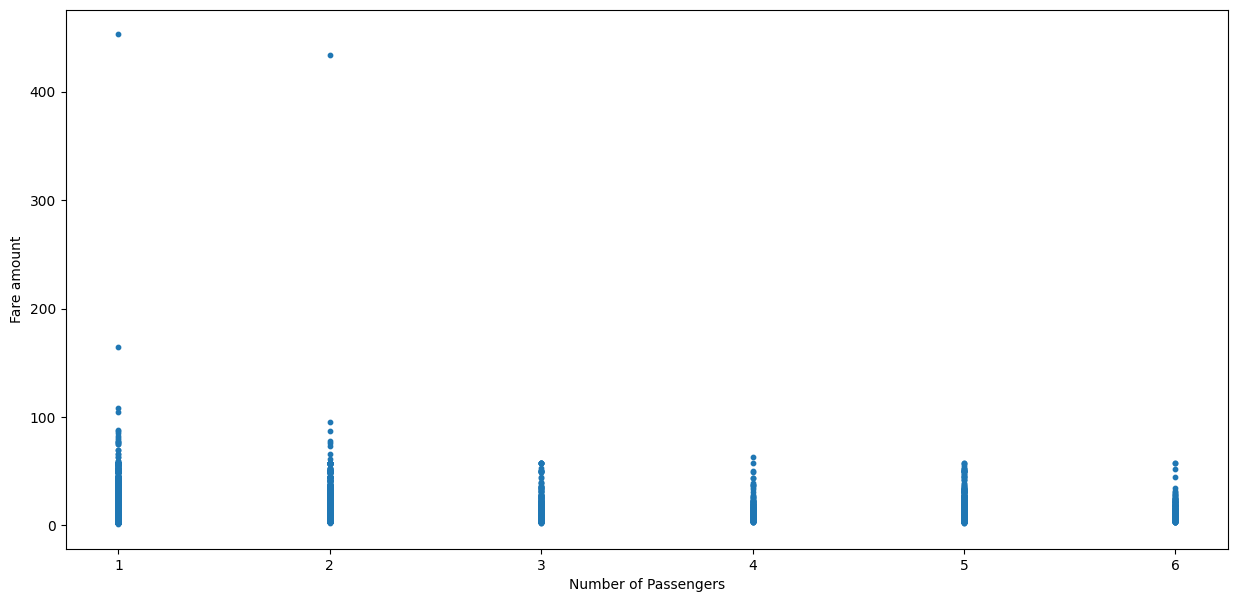

In [156]:
# Relationship beetween number of passengers and Fare

plt.figure(figsize=(15,7))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=10)
plt.xlabel('Number of Passengers')
plt.ylabel('Fare amount')
plt.show()

OBSERVATIONS
By seeing the above plots we can easily conclude that:

1. Single travelling passengers are most frequent travellers.
2. At the sametime, we can also conclude that highest Fare are coming from single & double travelling passengers.

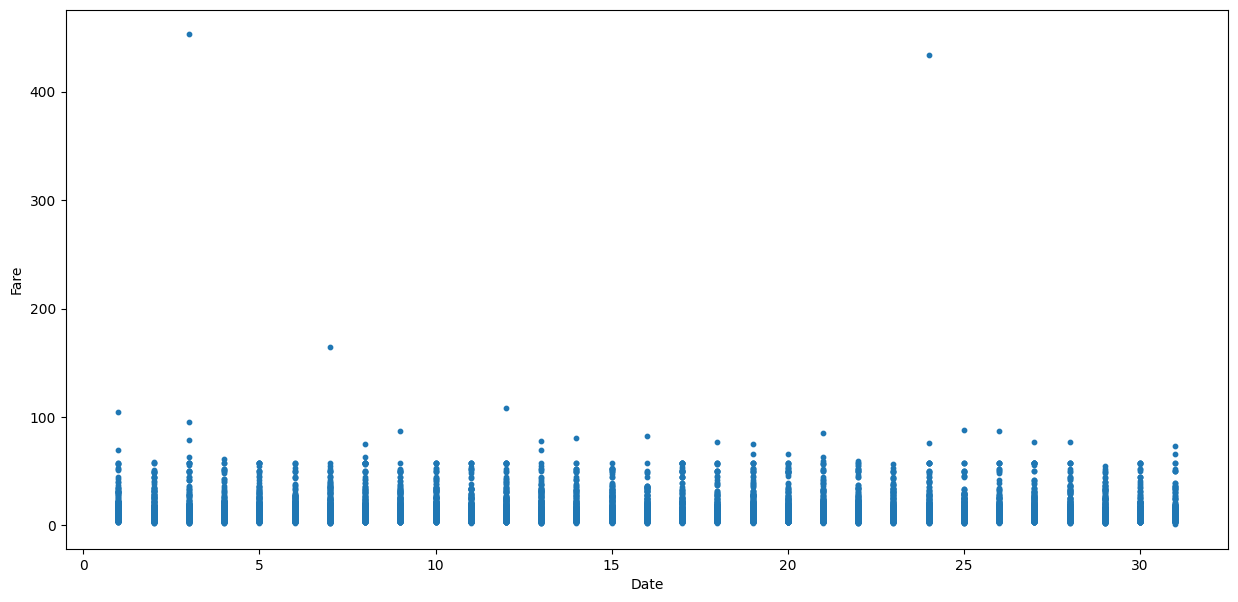

In [157]:
# Relationship between date and Fare

plt.figure(figsize=(15,7))
plt.scatter(x=train['Date'], y=train['fare_amount'], s=10)
plt.xlabel('Date')
plt.ylabel('Fare')
plt.show()

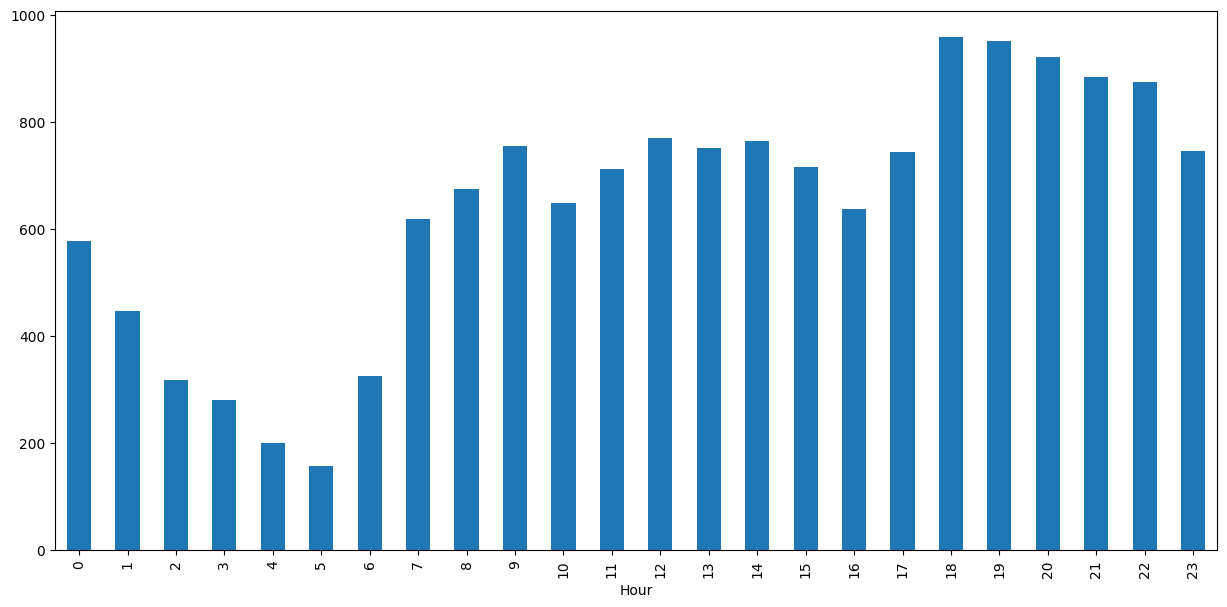

In [158]:
plt.figure(figsize=(15,7))
train.groupby(train["Hour"])['Hour'].count().plot(kind="bar")
plt.show()

Lowest cabs at 5 AM and highest at around 7 PM i.e the office rush hours.

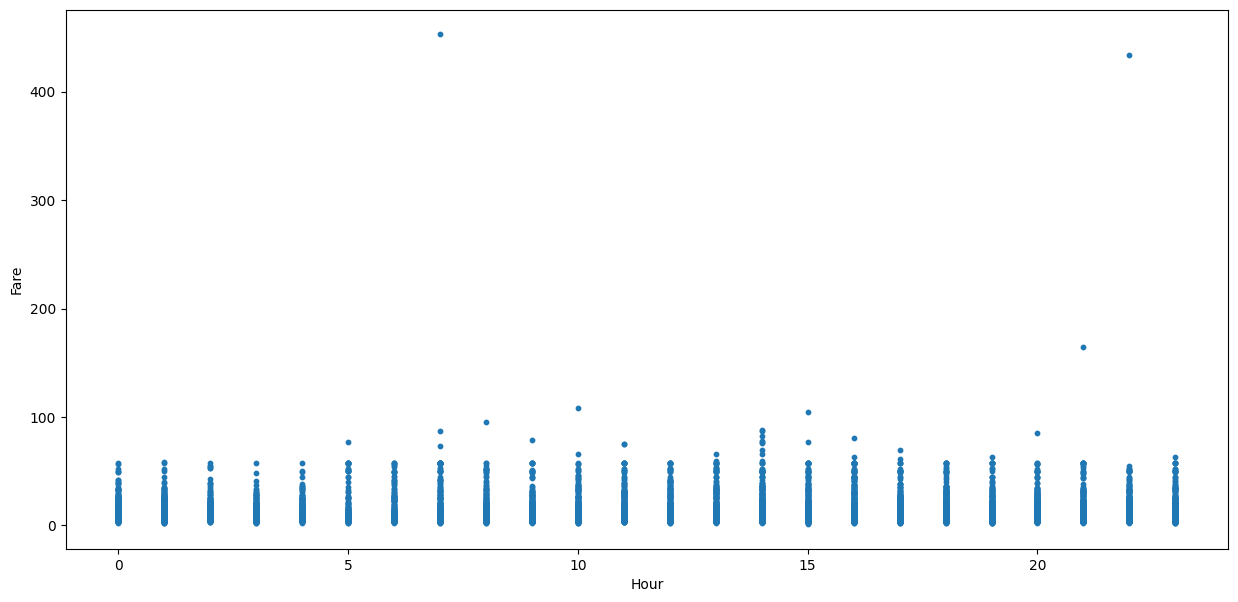

In [159]:
#Relationship between Time and Fare

plt.figure(figsize=(15,7))
plt.scatter(x=train['Hour'], y=train['fare_amount'], s=10)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.show()

OBSERVATIONS

1. From the above plot, We can observe that the cabs taken at 7 am and 23(11 Pm) are the costliest.
2. Hence we can assume that cabs taken early in morning and late at night are costliest

<Axes: xlabel='Day', ylabel='count'>

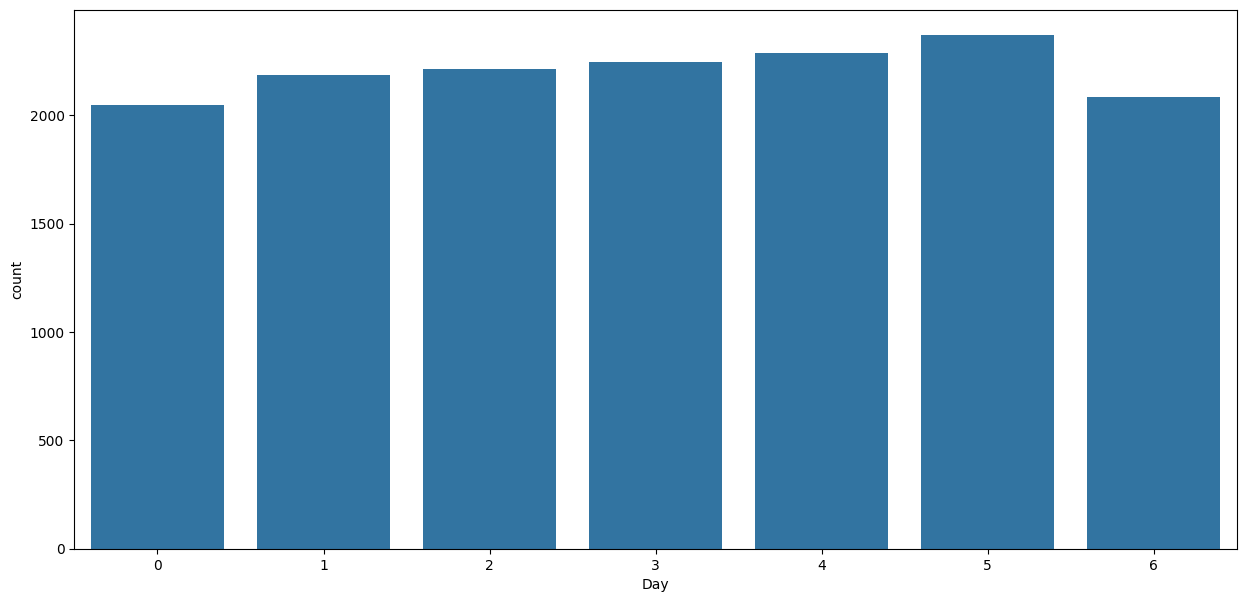

In [160]:
# Impact of Day on the number of cab rides

plt.figure(figsize=(15,7))
sns.countplot(x="Day", data=train)

OBSERVATIONS

The day of the week does not seem to have much influence on the number of cabs ride.

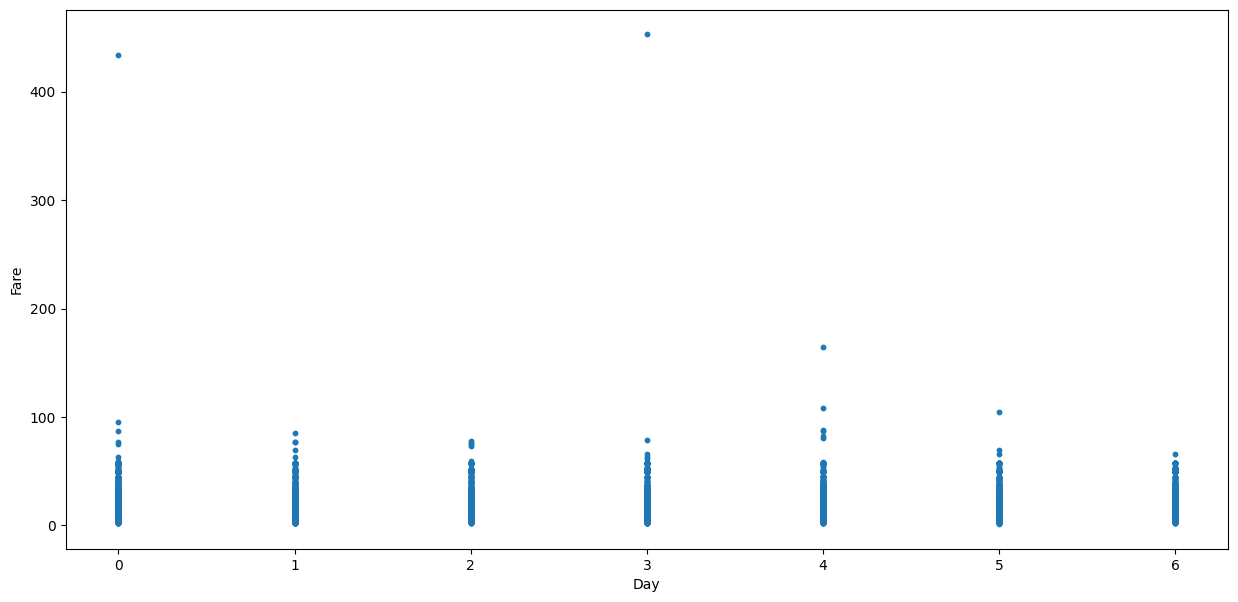

In [161]:
#Relationships between day and Fare

plt.figure(figsize=(15,7))
plt.scatter(x=train['Day'], y=train['fare_amount'], s=10)
plt.xlabel('Day')
plt.ylabel('Fare')
plt.show()

OBSERVATIONS

1. The highest fare seem to be on a Sunday, Monday and Thursday, and the low on Wednesday and Saturday.
2. May be due to low demand of the cabs on saturdays the cab fare is low and high demand of cabs on sunday and monday shows the high fare prices

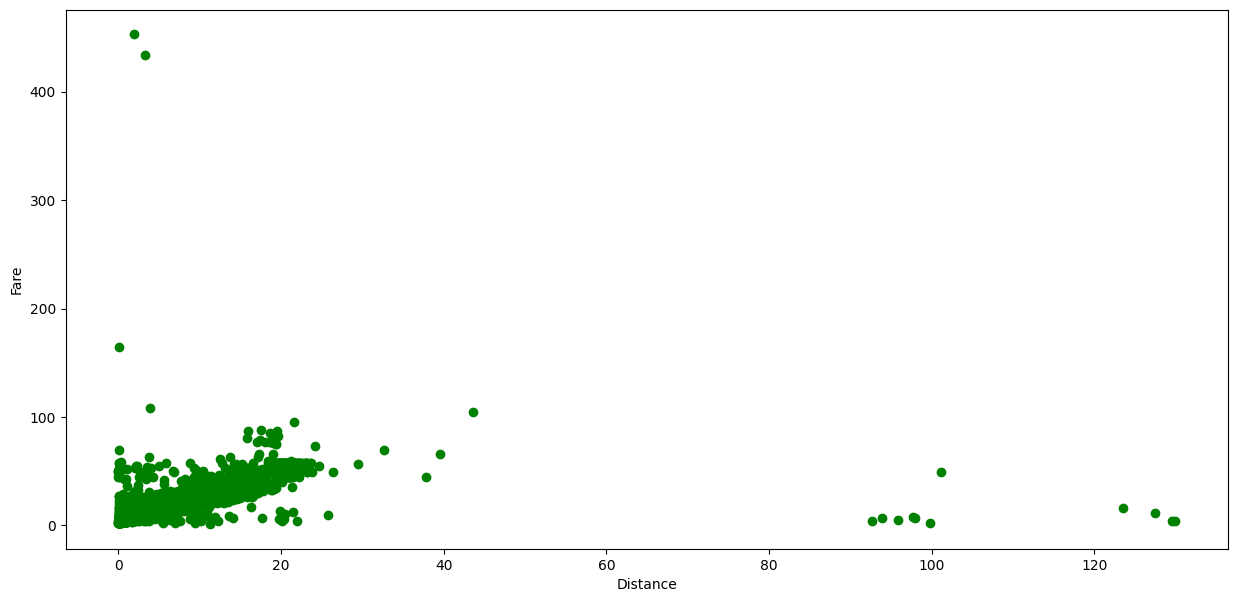

In [162]:
#Relationship between distance and fare 

plt.figure(figsize=(15,7))
plt.scatter(x = train['distance'],y = train['fare_amount'],c = "g")
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.show()

OBSERVATIONS

It is quite obvious that distance will effect the amount of fare.

FEATURE SCALING